In [1]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
from pyMRI.utils import RMSE
import seaborn as sns
from typing import Literal

In [2]:
metabolites = pymri.METABOLITES

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


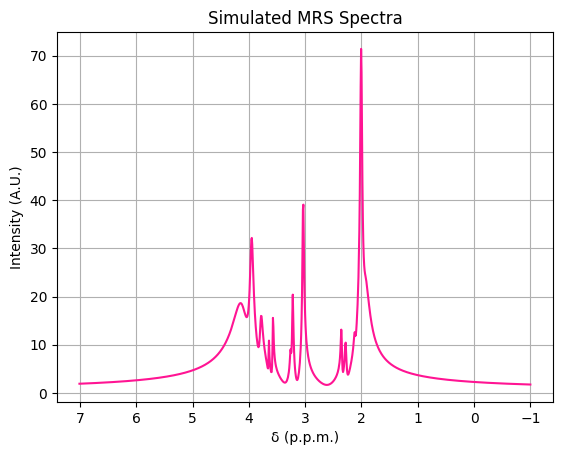

In [3]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

pymri.plot_chem_shifts(freqs, sig_fft, 1.0)

In [4]:
L = 0.4
noise_threshold = 30
rcond=1e-15
L_ = int(L*sig.size)

In [5]:
sample_snrs = np.array([0.25, 0.50, 0.75, 1.0, 2.5, 5.0, 10.0, 25.0, 50.0, 75.0, 100.0])

SNR = sample_snrs[6]
print(SNR)

10.0


In [6]:
print(np.max(np.log10(t2s)), np.min(np.log10(t2s)))

-0.6532559453951512 -2.1804560644581312


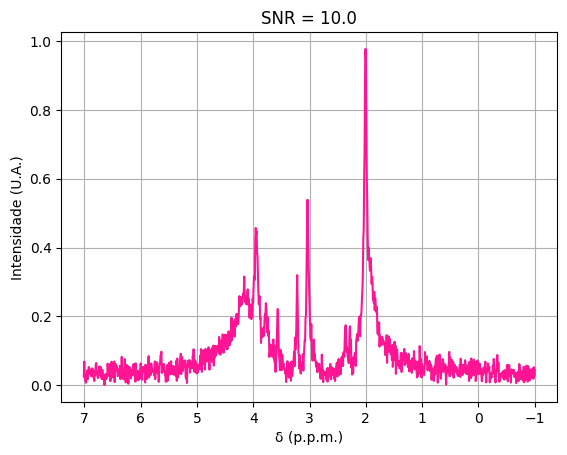

In [7]:
sig_fft_ = sig_fft/np.nanmax(sig_fft)

c_sig_fft = awgn(sig_fft_, SNR)
c_sig = np.fft.ifft(np.fft.ifftshift(c_sig_fft))

pymri.plot_chem_shifts(freqs, c_sig_fft, title=f"SNR = {SNR}", ylabel="Intensidade (U.A.)")

In [8]:
f_sig, z, r = pymri.filter_sig(c_sig, L, noise_threshold, 
                                        return_poles_and_res=True, 
                                        return_full_arrays=True, 
                                        rcond=rcond, 
                                        zero_filtering=rcond)

s0s_, phis_, omegas_, t2s_ = pymri.calculate_variables_from_z_and_r(z, r, dt)
t2s_ = 1/t2s_

In [9]:
lower_order = -2.3
higher_order = -0.5
lower_order_arr = np.log10(np.abs(t2s_)) <= lower_order
higher_order_arr = np.log10(np.abs(t2s_)) > higher_order
negative_arr = t2s_ <= 0.0
t2_filter_arr = np.bitwise_and( np.bitwise_and( np.bitwise_not(lower_order_arr), np.bitwise_not(higher_order_arr) ), np.bitwise_not(negative_arr))

print("T2")
print(f"Ordem absoluta menor que {lower_order}\t : {t2s_[lower_order_arr].size}")
print(f"Ordem absoluta maior que {higher_order}\t : {t2s_[higher_order_arr].size}")
print(f"Negativos\t\t\t: {t2s_[negative_arr].size}")
print(f"Restantes\t\t\t: {t2s_[t2_filter_arr].size}")

T2
Ordem absoluta menor que -2.3	 : 2
Ordem absoluta maior que -0.5	 : 489
Negativos			: 112
Restantes			: 323


In [10]:
t2_filtered_s0 = s0s_[t2_filter_arr]
t2_filtered_omega = omegas_[t2_filter_arr]
t2_filtered_phi = phis_[t2_filter_arr]
t2_filtered_t2 = t2s_[t2_filter_arr]

In [11]:
t2_filtered_pop = pymri.population(t2_filtered_omega, t2_filtered_t2, t2_filtered_s0, t2_filtered_phi)

t2_filtered_sig, t = pymri.population_transverse_decay( t0, tn, dt, t2_filtered_pop)
_, t2_filtered_sig_fft = pymri.fourier_spectrum(t2_filtered_sig, dt, B0)


([], [])

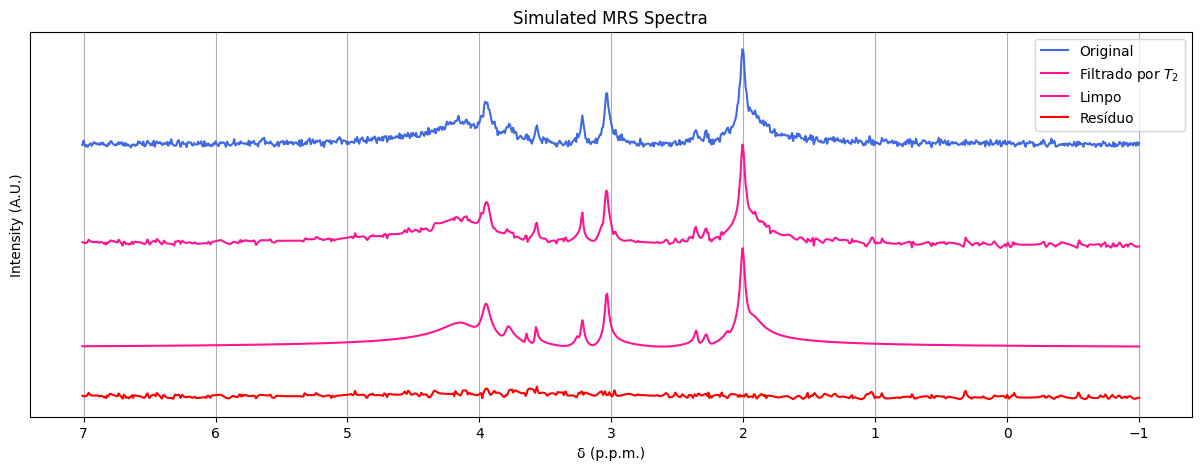

In [12]:
y_offset = 1.0

plt.figure(figsize=(15, 5))
pymri.plot_chem_shifts(freqs, c_sig_fft, y_offset=3*y_offset, label="Original", c = "royalblue")
pymri.plot_chem_shifts(freqs, t2_filtered_sig_fft, y_offset=2*y_offset, label=r"Filtrado por $T_2$")
pymri.plot_chem_shifts(freqs, sig_fft_, y_offset=1*y_offset, label="Limpo")
pymri.plot_chem_shifts(freqs, sig_fft_ - t2_filtered_sig_fft, y_offset=0.5*y_offset, label="Resíduo", c = "red")
plt.legend()
plt.yticks([])

## Filtro por $\omega$

In [13]:
def filter_freqs(omegas_ref : np.array, omegas_arr, delta : float):
    mask = np.full_like(omegas_arr, False, dtype=bool)

    for i in range(omegas_ref.size):
        mask = np.bitwise_or(mask, np.bitwise_and(omegas_arr > omegas_ref[i] - delta, omegas_arr <= omegas_ref[i] + delta)) 

    return mask

In [14]:
omegas_mask = filter_freqs(ws, omegas_, 100.0)

In [15]:
omegas_and_t2_filter = np.bitwise_and(omegas_mask, t2_filter_arr)

In [16]:
print("T2 e Omega")
print(f"Filtrando por proximidade aos omegas originais : {omegas_[omegas_mask].size}")
print(f"Filtrando por T2 e por omegas : {omegas_[omegas_and_t2_filter].size}")

T2 e Omega
Filtrando por proximidade aos omegas originais : 100
Filtrando por T2 e por omegas : 50


In [17]:
omegas_t2_filtered_s0 = s0s_[omegas_and_t2_filter]
omegas_t2_filtered_omega = omegas_[omegas_and_t2_filter]
omegas_t2_filtered_phi = phis_[omegas_and_t2_filter]
omegas_t2_filtered_t2 = t2s_[omegas_and_t2_filter]

In [18]:
omegas_t2_filtered_pop = pymri.population(omegas_t2_filtered_omega, omegas_t2_filtered_t2, omegas_t2_filtered_s0, omegas_t2_filtered_phi)

omegas_t2_filtered_sig, t = pymri.population_transverse_decay( t0, tn, dt, omegas_t2_filtered_pop)
_, omegas_t2_filtered_sig_fft = pymri.fourier_spectrum(omegas_t2_filtered_sig, dt, B0)


([], [])

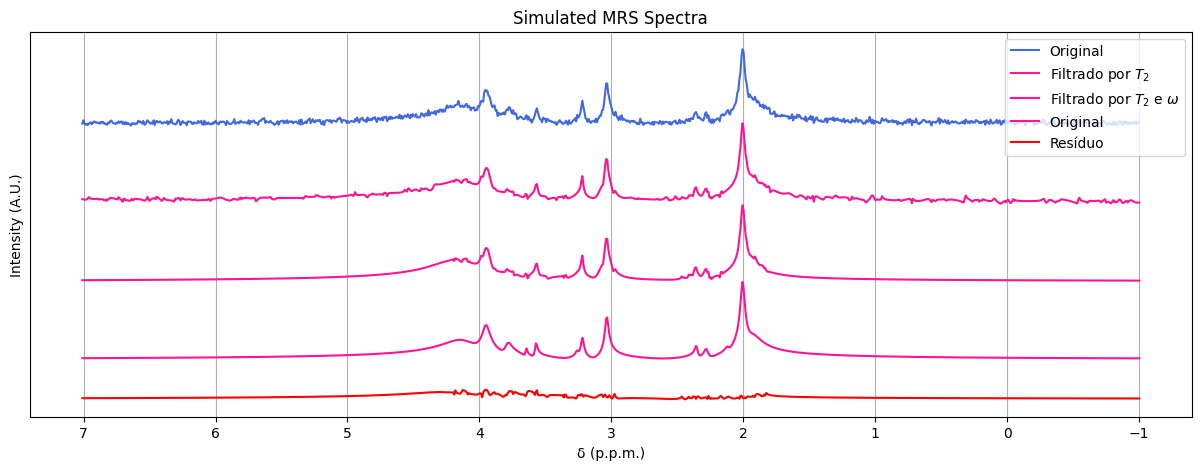

In [19]:
y_offset = 1.0

plt.figure(figsize=(15, 5))
pymri.plot_chem_shifts(freqs, c_sig_fft, y_offset=4*y_offset, label="Original", c = "royalblue")
pymri.plot_chem_shifts(freqs, t2_filtered_sig_fft, y_offset=3*y_offset, label=r"Filtrado por $T_2$")
pymri.plot_chem_shifts(freqs, omegas_t2_filtered_sig_fft, y_offset=2*y_offset, label=r"Filtrado por $T_2$ e $\omega$")
pymri.plot_chem_shifts(freqs, sig_fft_, y_offset=1*y_offset, label="Original")
pymri.plot_chem_shifts(freqs, sig_fft_ - omegas_t2_filtered_sig_fft, y_offset=0.5*y_offset, label="Resíduo", c = "red")
plt.legend()
plt.yticks([])

O filtro por frequência parece funcionar relativamente bem.

## Filtro por fase?

In [27]:
fase_0 = 0.0
fase_2pi = 2*np.pi

alpha = 0.2

phi_offset = alpha*fase_2pi

phi_filter = np.full_like(omegas_, False, dtype = bool)

In [28]:
phi_filter = np.bitwise_or(phi_filter, phis_ <= fase_0 + phi_offset)
phi_filter = np.bitwise_or(phi_filter, phis_ >= fase_2pi - phi_offset)

print(f"Fases antes de {fase_0 + phi_offset} e além de {fase_2pi - phi_offset} : {phis_[phi_filter].size}")

Fases antes de 1.2566370614359172 e além de 5.026548245743669 : 342


In [29]:
phi_omegas_and_t2_filter = np.bitwise_and(phi_filter, omegas_and_t2_filter)

In [30]:
phi_omegas_t2_filtered_s0 = s0s_[phi_omegas_and_t2_filter]
phi_omegas_t2_filtered_omega = omegas_[phi_omegas_and_t2_filter]
phi_omegas_t2_filtered_phi = phis_[phi_omegas_and_t2_filter]
phi_omegas_t2_filtered_t2 = t2s_[phi_omegas_and_t2_filter]

In [31]:
phi_omegas_t2_filtered_pop = pymri.population(phi_omegas_t2_filtered_omega, phi_omegas_t2_filtered_t2, phi_omegas_t2_filtered_s0, phi_omegas_t2_filtered_phi)

phi_omegas_t2_filtered_sig, t = pymri.population_transverse_decay( t0, tn, dt, phi_omegas_t2_filtered_pop)
_, phi_omegas_t2_filtered_sig_fft = pymri.fourier_spectrum(phi_omegas_t2_filtered_sig, dt, B0)


([], [])

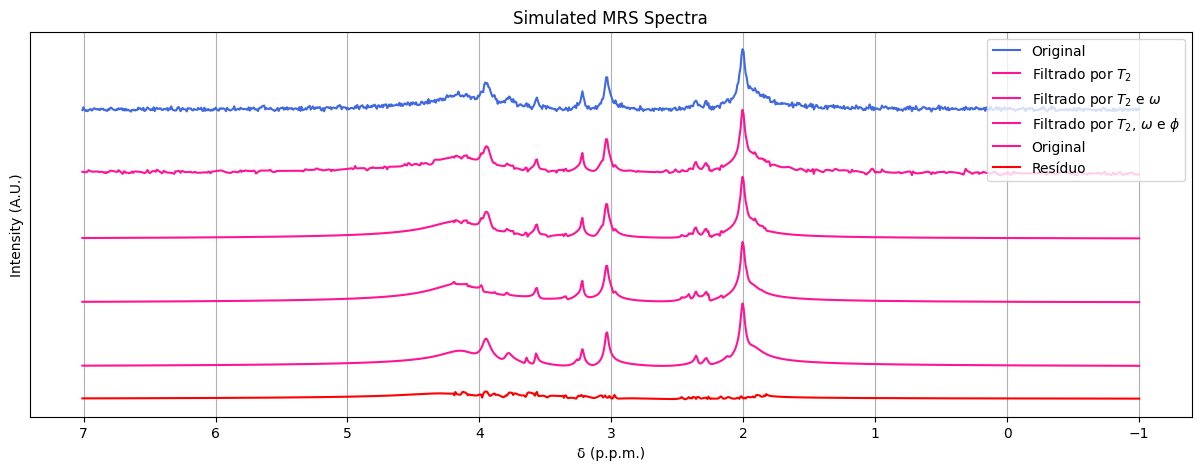

In [32]:
y_offset = 1.0

plt.figure(figsize=(15, 5))
pymri.plot_chem_shifts(freqs, c_sig_fft, y_offset=5*y_offset, label="Original", c = "royalblue")
pymri.plot_chem_shifts(freqs, t2_filtered_sig_fft, y_offset=4*y_offset, label=r"Filtrado por $T_2$")
pymri.plot_chem_shifts(freqs, omegas_t2_filtered_sig_fft, y_offset=3*y_offset, label=r"Filtrado por $T_2$ e $\omega$")
pymri.plot_chem_shifts(freqs, phi_omegas_t2_filtered_sig_fft, y_offset=2*y_offset, label=r"Filtrado por $T_2$, $\omega$ e $\phi$")
pymri.plot_chem_shifts(freqs, sig_fft_, y_offset=1*y_offset, label="Original")
pymri.plot_chem_shifts(freqs, sig_fft_ - omegas_t2_filtered_sig_fft, y_offset=0.5*y_offset, label="Resíduo", c = "red")
plt.legend()
plt.yticks([])

O filtro por fase parece não dar certo, e é possível ir além nessa análise: Filtrando fases longe do zero distorce ou até exclui os picos originais, indicando duas possíveis coisas:

1. Os picos de fato fragmentam-se em vários picos menores, principalmente em picos com SNR relativo baixo, perdendo completamente suas características individuais.
2. As fases são distorcidas de maneira significativa, deslocando os picos originais e diminuindo sua intensidade.

**FAZER UMA ANÁLISE DOS PARÂMETROS $M_0$, $\phi$, $\omega$ e $T_2$ DO ERRO**

## Picos

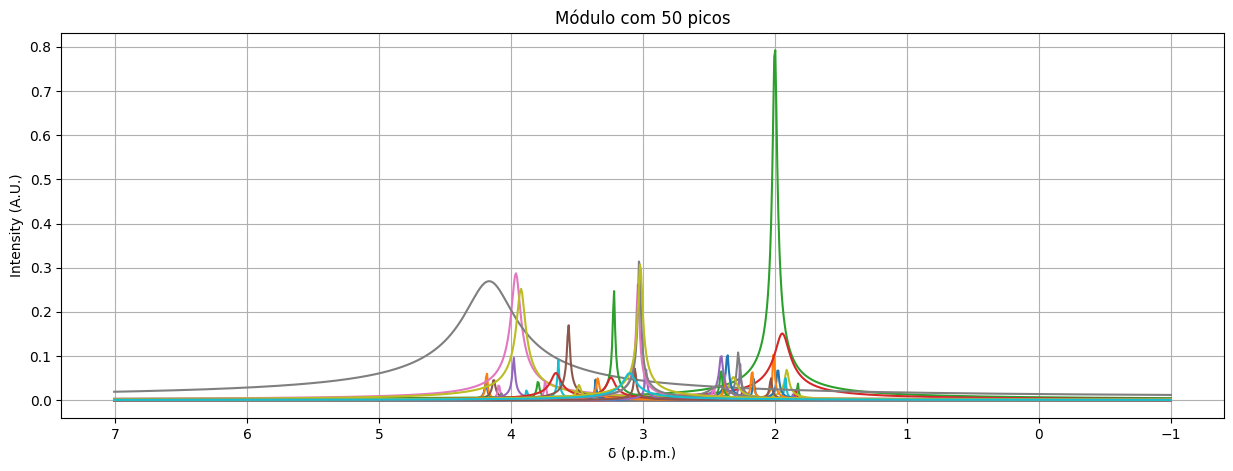

In [33]:
n = omegas_t2_filtered_omega.size
individual_sigs = np.zeros((n, 2048), dtype = np.complex128)

for i in range(n):
    _pop = pymri.population(np.array([omegas_t2_filtered_omega[i]]), np.array([omegas_t2_filtered_t2[i]]), np.array([omegas_t2_filtered_s0[i]]), np.array([omegas_t2_filtered_phi[i]]))
    individual_sigs[i] = pymri.population_transverse_decay(t0, tn, dt, _pop)[0]

plt.figure(figsize=(15, 5))
for j in range(n): 
    freqs, sig_fft = pymri.fourier_spectrum( individual_sigs[j], dt, B0)
    pymri.plot_chem_shifts(freqs, sig_fft, 1.0, c = None, plot_type="abs", title=f"Módulo com {n} picos")